# Machine Learning 2 Assignment 1
***by Péter Szilvási***

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression

prng = np.random.RandomState(20240322)

In [2]:
# import from github
data = pd.read_csv('https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/real_estate/real_estate.csv')

In [3]:
# fetch dataset to get variable descriptions
real_estate_valuation = fetch_ucirepo(id=477)
real_estate_valuation['variables']

,name,role,type,demographic,description,units,missing_values
0,No,ID,Integer,None,None,None,no
1,X1 transaction date,Feature,Continuous,None,"for example, 2013.250=2013 March, 2013.500=201...",None,no
2,X2 house age,Feature,Continuous,None,None,year,no
3,X3 distance to the nearest MRT station,Feature,Continuous,None,None,meter,no
4,X4 number of convenience stores,Feature,Integer,None,number of convenience stores in the living cir...,integer,no
5,X5 latitude,Feature,Continuous,None,"geographic coordinate, latitude",degree,no
6,X6 longitude,Feature,Continuous,None,"geographic coordinate, longitude",degree,no
7,Y house price of unit area,Target,Continuous,None,"10000 New Taiwan Dollar/Ping, where Ping is a ...",10000 New Taiwan Dollar/Ping,no


In [4]:
data.head()

,id,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


# EDA

In [5]:
data.house_price_of_unit_area.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
90%       54.940000
95%       59.175000
99%       70.883000
max      117.500000
Name: house_price_of_unit_area, dtype: float64

<Axes: >

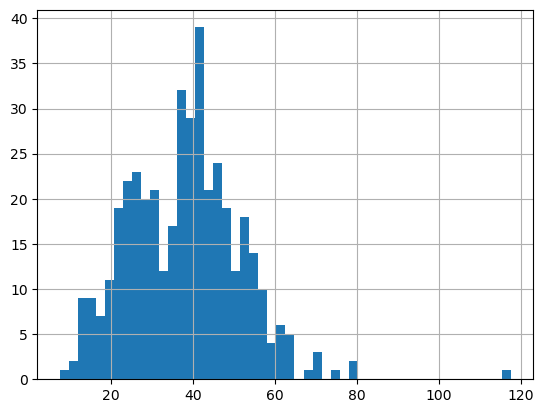

In [6]:
data.house_price_of_unit_area.hist(bins=50)

In [7]:
data.loc[data['house_price_of_unit_area'] == 117.500000]

,id,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
270,271,2013.333,10.8,252.5822,1,24.9746,121.53046,117.5


In [8]:
# this flat is unnecessarily expensive, drop it
data = data.drop(index=data.loc[data['house_price_of_unit_area'] == 117.500000].index)

# Splitting Data

In [9]:
data_sample = data.sample(frac=0.2,random_state=prng)
outcome = data_sample["house_price_of_unit_area"]
features = data_sample[['house_age',
                        'distance_to_the_nearest_MRT_station',
                        'number_of_convenience_stores',]]


X_train, X_test, y_train, y_test = train_test_split(features, outcome,test_size=0.3, random_state=prng)

**Think about an appropriate loss function you can use to evaluate your predictive models.**
**What is the risk (from a business perspective) that you would have to take by making a wrong prediction?**


I will be using RMSLE as my loss function. I choose this as compared to RMSE, it gives me relative errors rather than absolute ones, and I think that for properties there is a lot of variance in price and capturing relative errors makes more sense. 

A risk for us is how if we over predict the real price, there is a different effect to it compared to under-prediction. For a seller, under-predicting is more costly as they lose that money, but if they just over-predict, then they will only lose time, until they re-adjust and lower their prices.

In [10]:
# define loss function
def calculateRMSLE(prediction, y_obs):
    return np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) -
                np.log(y_obs + 1)
            )**2
        )
    )

**Build a simple benchmark model and evaluate its performance on the hold-out set**
**(using your chosen loss function).**

In [11]:
# estimate benchmark model
benchmark = np.mean(y_train)
benchmark_result = ["Benchmark", calculateRMSLE(benchmark, y_train), calculateRMSLE(benchmark, y_test)]

# collect results into a DataFrame
result_columns = ["Model", "Train", "Test"]
results = pd.DataFrame([benchmark_result], columns=result_columns)
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423


**Build a simple linear regression model using a chosen feature and evaluate its**
**performance.**

**Would you launch your evaluator web app using this model?**


In [12]:
simple_lin_reg = LinearRegression().fit(X_train[["house_age"]], y_train)
simple_lin_reg_prediction = simple_lin_reg.predict((X_train[['house_age']]))
simple_lin_reg_prediction_holdout = simple_lin_reg.predict((X_test[['house_age']]))

simple_lin_reg_result = ["Simple OLS",
                         calculateRMSLE(simple_lin_reg_prediction, y_train),
                         calculateRMSLE(simple_lin_reg_prediction_holdout, y_test)]
# append it to the Original results dataframe using loc()
results.loc[len(results)] = simple_lin_reg_result
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173


I would not launch my app with this Simple OLS Model, as it's not even better than my Benchmark. Also there is a lot depending on the RandomSeed. The sample we are using might be too small.

**Build a multivariate linear model with all the meaningful variables available.**

**Did it improve the predictive power?**


In [13]:
# define variable sets
multivariate_features = ['house_age','distance_to_the_nearest_MRT_station','number_of_convenience_stores']

# fit the model
multivariate_lin_reg = LinearRegression().fit(X_train[multivariate_features], y_train)

# predictions for training data
multivariate_lin_reg_prediction = multivariate_lin_reg.predict((X_train[multivariate_features]))

# predictions for test sample
multivariate_lin_reg_prediction_holdout = multivariate_lin_reg.predict((X_test[multivariate_features]))

multivariate_lin_reg_result = ["Multivariate OLS",
                         calculateRMSLE(multivariate_lin_reg_prediction, y_train),
                         calculateRMSLE(multivariate_lin_reg_prediction_holdout, y_test)]
# append it to the Original results dataframe using loc()
results.loc[len(results)] = multivariate_lin_reg_result
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290


Including more variables improved the model a lot. It performs better on both the training and the test set as well.

## Feature engineering 

- making sense of latitude&longitude by calculating the distance from the city center
- make sense or transaction date
- including squares and interactions (include polynomials and interactions in the pipelines)

In [14]:
# Feature Engineering on the full dataset, so we only have to do it once
# city center coordinates
center_x = 121.53185 # longitude
center_y = 25.04776 # latitude

lat_to_meters = 111132.92  # 1 degree latitude ≈ 111132.92 meters
lon_to_meters = 111412.84  # 1 degree longitude ≈ 111412.84 meters (at latitude 25°)

# create fucntion to calculate distance from center
# simple Pythagoras Theorem, i neglect earth's curviture, as these are not so far distances 
def calculate_distance(x,y):
    distance = np.sqrt(((center_x - x)*lon_to_meters)**2+((center_y - y)*lat_to_meters)**2)
    return distance

# apply function to create new column
data['distance_from_center'] = calculate_distance(data['longitude'],data['latitude'])

# create year and motnh as categorical variables
data['transaction_year'] = data['transaction_date'].astype(int) # don't set to categorical yet, we need it for subtraction
data['transaction_month'] = (((data.transaction_date - data.transaction_year)*12).astype(int)+1).astype('category')
data['transaction_year'] = data['transaction_year'].astype('category')

In [15]:
data.head()

,id,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,distance_from_center,transaction_year,transaction_month
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,7259.621837,2012,12
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,7541.028229,2012,12
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,6834.690125,2013,7
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,6834.690125,2013,7
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,7691.585452,2012,10


In [16]:
# do the same splitting as before on the engineered dataset, random seed ensures the same samples
data_sample = data.sample(frac=0.2,random_state=prng)
outcome = data_sample["house_price_of_unit_area"]
features = data_sample[['house_age',
                        'distance_to_the_nearest_MRT_station',
                        'number_of_convenience_stores',
                        'distance_from_center',
                        'transaction_year',
                        'transaction_month',
                        ]]


X_train, X_test, y_train, y_test = train_test_split(features, outcome,test_size=0.3, random_state=prng)

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

# define create interactions and drop no variance as helpers
create_interactions_and_polys = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
drop_no_variance = VarianceThreshold()

In [18]:
# Build a pipeline

dummy_features = ['transaction_year','transaction_month']
one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")


create_categorical_features = Pipeline([
    ("dummify",one_hot_encoder),
    ("create_interactions", create_interactions_and_polys),
    ("drop_zero_variance", drop_no_variance)
    ])

pipe_whole_process = Pipeline([
    ("create_features", ColumnTransformer([("choose_and_transform_features", create_categorical_features,dummy_features)])),
    ("ols", LinearRegression())
])
pipe_whole_process

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['transaction_year',
                                                   'transaction_month'])])),
                ('ols', LinearRegression())])

In [19]:
# fit the model
pipe_whole_process.fit(X_train, y_train)

# calculate train and test error
train_error = calculateRMSLE(pipe_whole_process.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_whole_process.predict(X_test), y_test)

feature_engineered_ols = ["FE OLS",train_error,test_error]

results.loc[len(results)] = feature_engineered_ols
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290
3,FE OLS,0.341590,0.271908


## Training more flexible models - e.g. random forest or gradient boosting


In [20]:
# simple Decision tree
from sklearn import tree

steps = [
    ('tree',tree.DecisionTreeRegressor(max_depth=5, random_state = prng))
]
pipe_tree = Pipeline(steps)

pipe_tree.fit(X_train, y_train)

train_error = calculateRMSLE(pipe_tree.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_tree.predict(X_test), y_test)

tree_result = ["Tree", train_error, test_error]
results.loc[len(results)] = tree_result
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290
3,FE OLS,0.341590,0.271908
4,Tree,0.099918,0.216568


In [21]:
# random forest
from sklearn.ensemble import RandomForestRegressor

steps = [
    ("random_forest", RandomForestRegressor(random_state=prng))
]
pipe_rf = Pipeline(steps)

pipe_rf.fit(X_train, y_train)

train_error = calculateRMSLE(pipe_rf.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_rf.predict(X_test), y_test)

rf_result = ["Random Forest", train_error, test_error]
results.loc[len(results)] = rf_result
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290
3,FE OLS,0.341590,0.271908
4,Tree,0.099918,0.216568
5,Random Forest,0.088331,0.202586


In [22]:
pipe_rf["random_forest"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': RandomState(MT19937) at 0x148292DDB40,
 'verbose': 0,
 'warm_start': False}

In [23]:
# xgboost
import xgboost as xgb

steps = [
    ("xgb", xgb.XGBRegressor(enable_categorical=True,random_state=prng))
]
pipe_xgb = Pipeline(steps)

pipe_xgb.fit(X_train, y_train)

train_error = calculateRMSLE(pipe_xgb.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_xgb.predict(X_test), y_test)

xgb_result = ["XGB", train_error, test_error]
results.loc[len(results)] = xgb_result
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290
3,FE OLS,0.341590,0.271908
4,Tree,0.099918,0.216568
5,Random Forest,0.088331,0.202586
6,XGB,0.034182,0.202898


**Would you launch your web app now?
What options you might have to further improve the prediction performance?**


My new and improved models are significantly better on the training set, however they are overfitting my data. Even though my Test sample predictions improved, they are still above 0.20 RMSLE.

Even if this way an acceptable loss value, there is a lot depending on my Random Seed so I would not launch anything this unstable.

To further improve the performance, I could:
- use more data for training
- tune hyperparameters with GridSearch
- Cross-Validation
- try to get new variables (features), there is still a lot of other things that affect flat, building prices

**Rerun three of your previous models (including both flexible and less flexible ones)
on the full train set. Ensure that your test result remains comparable by keeping that dataset
intact.  Did it improve the predictive power of your
models? Where do you observe the biggest improvement? Would you launch your web app
now?**


In [24]:
# ensure my test sample remains
real_estate_full = data.loc[~data.index.isin(X_test.index)]
print(f"Size of the full training set: {real_estate_full.shape[0]}, size of the test set: {len(X_test)}")

Size of the full training set: 388, size of the test set: 25


In [25]:
# do the same with y_train
y_train = data.loc[~data.index.isin(X_test.index)]['house_price_of_unit_area']

# also adjust X_train
X_train = real_estate_full.drop(columns=['house_price_of_unit_area','id','latitude','longitude','transaction_date'])

In [26]:
## Simple OLS Again
full_simple_lin_reg = LinearRegression().fit(X_train[["house_age"]], y_train)
full_simple_lin_reg_prediction = full_simple_lin_reg.predict((X_train[['house_age']]))
full_simple_lin_reg_prediction_holdout = full_simple_lin_reg.predict((X_test[['house_age']]))

full_simple_lin_reg_result = ["Full Simple OLS",
                         calculateRMSLE(full_simple_lin_reg_prediction, y_train),
                         calculateRMSLE(full_simple_lin_reg_prediction_holdout, y_test)]
# append it to the Original results dataframe using loc()
results.loc[len(results)] = full_simple_lin_reg_result

## Multivariate OLS Again
full_multivariate_lin_reg = LinearRegression().fit(X_train[multivariate_features], y_train)

# predictions for training data
full_multivariate_lin_reg_prediction = full_multivariate_lin_reg.predict((X_train[multivariate_features]))

# predictions for test sample
full_multivariate_lin_reg_prediction_holdout = full_multivariate_lin_reg.predict((X_test[multivariate_features]))

full_multivariate_lin_reg_result = ["Full Multivariate OLS",
                         calculateRMSLE(full_multivariate_lin_reg_prediction, y_train),
                         calculateRMSLE(full_multivariate_lin_reg_prediction_holdout, y_test)]
# append it to the Original results dataframe using loc()
results.loc[len(results)] = full_multivariate_lin_reg_result

In [27]:
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290
3,FE OLS,0.341590,0.271908
4,Tree,0.099918,0.216568
5,Random Forest,0.088331,0.202586
6,XGB,0.034182,0.202898
7,Full Simple OLS,0.380215,0.245631
8,Full Multivariate OLS,0.256418,0.278394


In [28]:
models = {'Full FE OLS': pipe_whole_process,  # for Feature Engineered OLS    
          'Full Tree': pipe_tree,
          'Full Random Forest': pipe_rf,
          'Full XGB': pipe_xgb}

# loop over pipelines to get new predictions
for name, model in models.items():
    model.fit(X_train, y_train)
    train_error = calculateRMSLE(model.predict(X_train), y_train)
    test_error = calculateRMSLE(model.predict(X_test), y_test)
    model_result = [name, train_error, test_error]
    results.loc[len(results)] = model_result

In [29]:
results

,Model,Train,Test
0,Benchmark,0.341876,0.341423
1,Simple OLS,0.329751,0.351173
2,Multivariate OLS,0.203478,0.237290
3,FE OLS,0.341590,0.271908
4,Tree,0.099918,0.216568
5,Random Forest,0.088331,0.202586
6,XGB,0.034182,0.202898
7,Full Simple OLS,0.380215,0.245631
8,Full Multivariate OLS,0.256418,0.278394
9,Full FE OLS,0.383720,0.251049


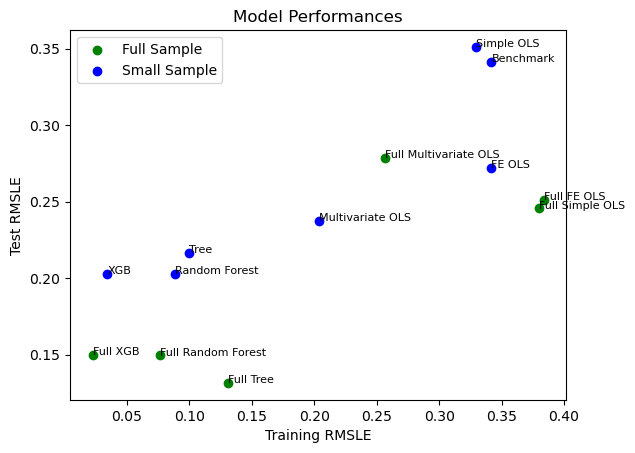

In [30]:
import matplotlib.pyplot as plt

# Create scatter plot for small models (blue)
plt.scatter(results[results['Model'].str.contains('Full')]['Train'],
            results[results['Model'].str.contains('Full')]['Test'], c='green', label='Full Sample')

# Create scatter plot for full models (green)
plt.scatter(results[~results['Model'].str.contains('Full')]['Train'],
            results[~results['Model'].str.contains('Full')]['Test'], c='blue', label='Small Sample')

# Add labels next to each point
for i, model in enumerate(results['Model']):
    plt.text(results['Train'][i], results['Test'][i], model, fontsize=8)

# Add labels and title
plt.xlabel('Training RMSLE')
plt.ylabel('Test RMSLE')
plt.title('Model Performances')

# Add legend
plt.legend()

# Show plot
plt.show()

As seen from the graph, models using the Full Sample have generally lower Test errors, while keeping to almost the same training errors. This is a good sign so we can say including more data improved our situation a lot.

My Simple OLS model improved the most, by almost 0.11 RMSLE, however, the second most improved is my overall best fit model, the simple Decision Tree.

I still wouldn't launch my web app as there is still a lot depending on the Random Seed, I believe the 413 observations we have are not enough to build a model on.